In [1]:
import sys
sys.path.append("/home/gridsan/vyuan/.local/lib/python3.9/site-packages")
sys.path.append("../../src")

In [2]:
import os
import json
from pathlib import Path

import torch

from utils import data_utils
from models import cbm
from plots import plots

In [3]:
root = Path.cwd().parent.parent.parent
os.chdir(root)

In [4]:
# change this to the correct model dir, everything else should be taken care of
load_dir = "saved_models/doctor_nurse_full_cbm_2023_06_05_11_27"
device = "cuda"

with open(os.path.join(load_dir, "args.txt"), "r") as f:
    args = json.load(f)
dataset = args["dataset"]
target_model, target_preprocess = data_utils.get_target_model(args["backbone"], device)
model = cbm.load_cbm(load_dir, device)

CBM_model(
  (backbone): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (proj_layer): Linear(in_features=256, out_features=33, bias=False)
  (final): L

In [5]:
val_d_probe = dataset+"_val"
cls_file = data_utils.LABEL_FILES[dataset]

val_data_t = data_utils.get_data(val_d_probe, preprocess=target_preprocess)
val_pil_data = data_utils.get_data(val_d_probe)

In [6]:
with open(cls_file, "r") as f:
    classes = f.read().split("\n")

with open(os.path.join(load_dir, "concepts.txt"), "r") as f:
    concepts = f.read().split("\n")

## Original prediction

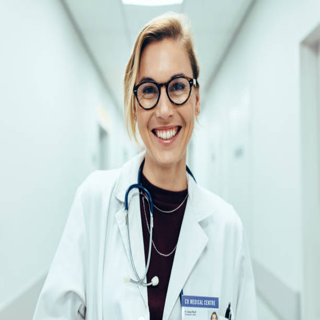

Image:2 Gt:doctor, 1st Pred:doctor, 0.517, 2nd Pred:nurse, -0.517


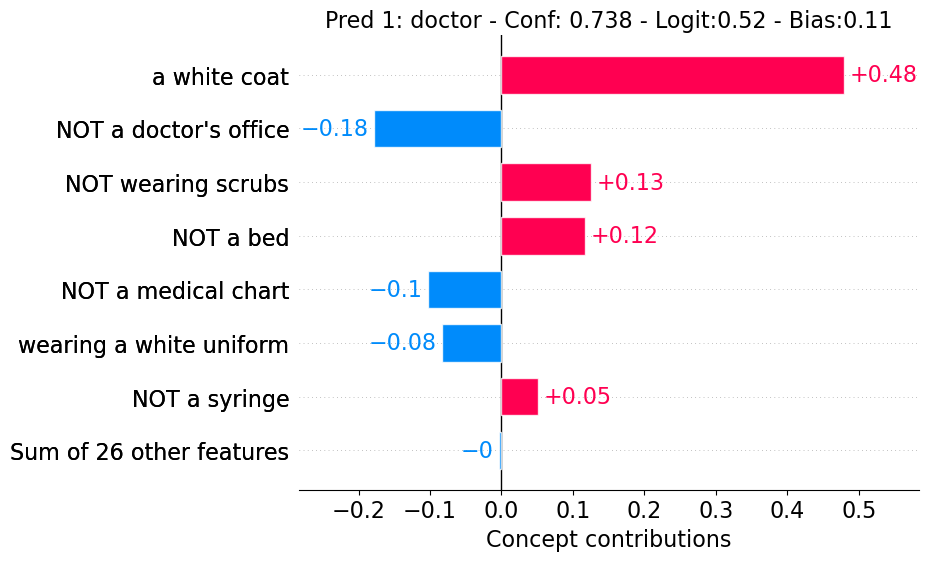

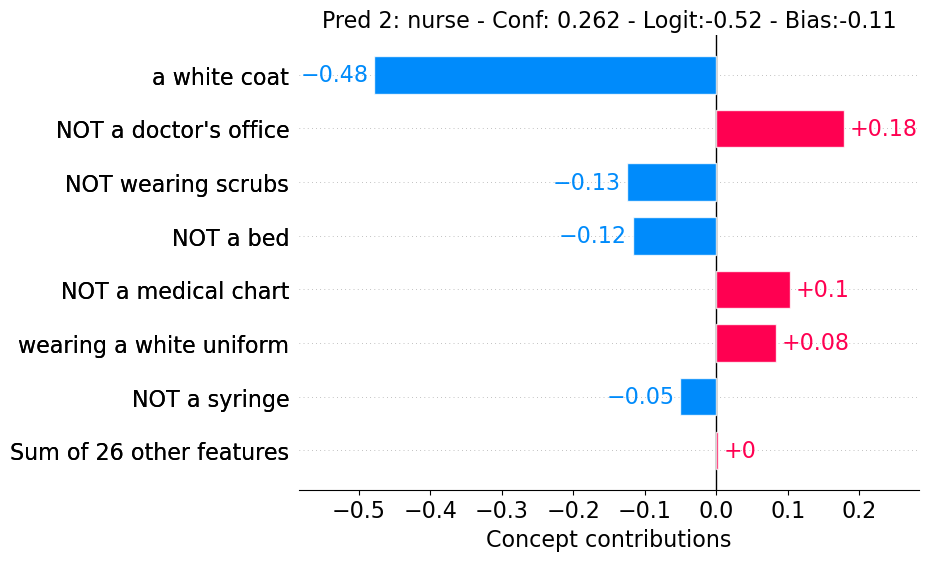

In [7]:
to_display = [2]

with torch.no_grad():
    for i in to_display:
        image, label = val_pil_data[i]
        x, _ = val_data_t[i]
        x = x.unsqueeze(0).to(device)
        display(image.resize([320,320]))
        outputs, concept_act = model(x)
        
        top_logit_vals, top_classes = torch.topk(outputs[0], dim=0, k=2)
        conf = torch.nn.functional.softmax(outputs[0], dim=0)
        print("Image:{} Gt:{}, 1st Pred:{}, {:.3f}, 2nd Pred:{}, {:.3f}".format(i, classes[int(label)], classes[top_classes[0]], top_logit_vals[0],
                                                                      classes[top_classes[1]], top_logit_vals[1]))
        
        for k in range(2):
            contributions = concept_act[0]*model.final.weight[top_classes[k], :]
            feature_names = [("NOT " if concept_act[0][i] < 0 else "") + concepts[i] for i in range(len(concepts))]
            values = contributions.cpu().numpy()
            max_display = min(int(sum(abs(values)>0.005))+1, 8)
            title = "Pred {}: {} - Conf: {:.3f} - Logit:{:.2f} - Bias:{:.2f}".format(k+1, classes[top_classes[k]],
                             conf[top_classes[k]], top_logit_vals[k], model.final.bias[top_classes[k]])
            plots.bar(values, feature_names, max_display=max_display, title=title, fontsize=16)

## Intervene on "a hat" to correct prediction

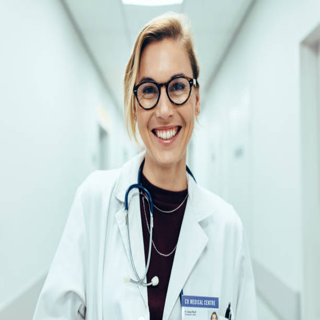

ValueError: 'a hat' is not in list

In [8]:
to_display = [2]

with torch.no_grad():
    for i in to_display:
        image, label = val_pil_data[i]
        x, _ = val_data_t[i]
        x = x.unsqueeze(0).to(device)
        display(image.resize([320,320]))
        
        _, concept_act = model(x)
        # Intervene to change hat activation to 0
        concept_act[0, concepts.index("a hat")] = 0
        outputs = model.final(concept_act)
        
        top_logit_vals, top_classes = torch.topk(outputs[0], dim=0, k=2)
        conf = torch.nn.functional.softmax(outputs[0], dim=0)
        print("Image:{} Gt:{}, 1st Pred:{}, {:.3f}, 2nd Pred:{}, {:.3f}".format(i, classes[int(label)], classes[top_classes[0]], top_logit_vals[0],
                                                                      classes[top_classes[1]], top_logit_vals[1]))
        
        for k in range(2):
            contributions = concept_act[0]*model.final.weight[top_classes[k], :]
            feature_names = [("NOT " if concept_act[0][i] < 0 else "") + concepts[i] for i in range(len(concepts))]
            values = contributions.cpu().numpy()
            max_display = min(int(sum(abs(values)>0.005))+1, 8)
            title = "Pred {}: {} - Conf: {:.3f} - Logit:{:.2f} - Bias:{:.2f}".format(k+1, classes[top_classes[k]],
                             conf[top_classes[k]], top_logit_vals[k], model.final.bias[top_classes[k]])
            plots.bar(values, feature_names, max_display=max_display, title=title, fontsize=16)